In [1]:
# path variables
import sys
project_path = '/Users/naresh/Downloads/DS/growth/nsl_v2/nsl_v2_final/'
sys.path.insert(0, project_path+'config')
from config import SQLQuery

# core libraries
import datetime
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pickle
import re
import nltk
import spacy
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
nlp = spacy.load("en_core_web_lg")

In [3]:
%load_ext autoreload
%autoreload 2
from stability_monitoring import *

In [4]:
q = SQLQuery('snowflake')

#### V1 Metrics Started

In [5]:
# north star customers definition
txn_days = 90
txn_credit_amount = 15000

In [8]:
# query to fetch the required data
df_raw_v1 = q("""

select *, date(APPLICATION_COMPLETE_DATETIME) as app_comp_date, 
month(APPLICATION_COMPLETE_DATETIME) as app_comp_month,
year(APPLICATION_COMPLETE_DATETIME) as app_comp_year
from "PROD_DB"."DATA"."APPLICATIONS"
where date(APPLICATION_COMPLETE_DATETIME) between '2022-10-01' and '2023-05-31'

    """)

df_raw_v1.shape

(115942, 117)

#### V1 Metrics Completed

In [10]:
REPLACE_BY_SPACE_RE = re.compile('[/()]{}\[\]\|@,:!*]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z ]')

def cleaning_gen(data):
    review = re.sub('[^a-zA-z]',' ',data)
    review = review.lower()
    review = BAD_SYMBOLS_RE.sub('',review)
    review = REPLACE_BY_SPACE_RE.sub(' ', review)
    doc = nlp(review)
    tokens = []
    for token in doc:
        tokens.append(token)
    tokens = [token.lemma_ for token in doc if token.pos_ in ['VERB','NOUN']]
    tokens = [c for c in tokens if c not in stop_words]
    tokens = [c for c in tokens if len(c)>1]
    tokens = ' '.join(tokens)
    return (tokens)

In [11]:
def data_preprocess_v1(df:pd.DataFrame):
    # estimated business numbers
    estimated_cols = ['estimated_monthly_revenue',
                      'check_deposit_amount',
                      'outgoing_ach_and_checks']

    # grouping all responses into 5K+ and 5K-
    for col in estimated_cols:
        df[col] = df[col].str.lower()
        df[col] = np.where(df[col].isin(['$5k +', '$50k +']), 1, 0)

    # industry type
    df['industry_category_name'] = df['industry_category_name'].str.lower()
    hdi_group = ['mining', 
                 'utilities', 
                 'professional, scientific, and technical services',
                 'real estate rental and leasing', 
                 'finance and insurance',
                 'health care and social assistance', 
                 'transportation and warehousing']
    df['industry_group'] = np.where(df['industry_category_name'].isin(hdi_group), 1, 0)
    df['industry_group'].value_counts()

    # business age
    df['date_of_establishment_dt'] = pd.to_datetime(df['date_of_establishment'], format='%Y-%m', errors='coerce').dropna()
    df['business_age'] = round((df['application_start_datetime'] - df['date_of_establishment_dt']) / np.timedelta64(1, 'Y'),2)
    df['business_age'] = df['business_age'].fillna(0)
    df['business_age_bucket'] = np.where(df['business_age'] <= 1, 1, 
                                        np.where((df['business_age']>1) & (df['business_age']<=3), 2, 3))
    df['business_age_bucket'].value_counts().sort_values()

    # business pitch
    bag_of_words = ['engineering','strategy','software','startup','firm','consulting','technology','datum',
                   'patient','development','project','team','film','term','lease','investment','agency',
                   'contract','contractor','practice','system']
    df['business_pitch_lema_spacy'] = df['business_pitch'].apply(cleaning_gen)
    df['bow_flag'] = np.where(df['business_pitch_lema_spacy'].str.contains('|'.join(bag_of_words)), 1, 0)
    
    return df
    

In [12]:
df_processed = data_preprocess_v1(df=df_raw_v1)

In [13]:
independent_features = ['estimated_monthly_revenue', 
                        'check_deposit_amount', 
                        'outgoing_ach_and_checks', 
                        'industry_group', 
                        'business_age_bucket', 
                        'bow_flag']

In [14]:
# df_processed.to_pickle(project_path+'data/psi_test_app_comp_data_oct22_may23.pkl')

In [15]:
df_processed.shape

(115942, 123)

In [33]:
df_processed['busi_age_3_flag'] = np.where(df_processed.business_age_bucket!=3, 0, 1)
df_processed['busi_age_2_flag'] = np.where(df_processed.business_age_bucket!=2, 0, 1)
df_processed['busi_age_1_flag'] = np.where(df_processed.business_age_bucket!=1, 0, 1)

In [49]:
df_processed[(df_processed.application_channel.str.lower()=='google') & 
            (df_processed.utm_source.str.lower()=='google')].shape

(56736, 126)

In [42]:
# Filter only google source apps
df_tmp = df_processed[df_processed.utm_source.str.lower()=='google']

In [43]:
df_tmp.shape

(56738, 126)

In [46]:
df_tmp2 = pd.DataFrame(df_processed.groupby(by=['app_comp_year','app_comp_month'])['application_id'].count())
df_tmp2 = pd.merge(df_tmp2, pd.DataFrame(df_tmp.groupby(by=['app_comp_year','app_comp_month']
                                                             )['estimated_monthly_revenue'].sum())
                  ,on=['app_comp_year','app_comp_month'], how='left')

df_tmp2 = pd.merge(df_tmp2, pd.DataFrame(df_tmp.groupby(by=['app_comp_year','app_comp_month']
                                                             )['check_deposit_amount'].sum())
                  ,on=['app_comp_year','app_comp_month'], how='left')

df_tmp2 = pd.merge(df_tmp2, pd.DataFrame(df_tmp.groupby(by=['app_comp_year','app_comp_month']
                                                             )['outgoing_ach_and_checks'].sum())
                  ,on=['app_comp_year','app_comp_month'], how='left')

df_tmp2 = pd.merge(df_tmp2, pd.DataFrame(df_tmp.groupby(by=['app_comp_year','app_comp_month']
                                                             )['industry_group'].sum())
                  ,on=['app_comp_year','app_comp_month'], how='left')

df_tmp2 = pd.merge(df_tmp2, pd.DataFrame(df_tmp.groupby(by=['app_comp_year','app_comp_month']
                                                             )['bow_flag'].sum())
                  ,on=['app_comp_year','app_comp_month'], how='left')

df_tmp2 = pd.merge(df_tmp2, pd.DataFrame(df_tmp.groupby(by=['app_comp_year','app_comp_month']
                                                             )['nsl_current'].sum())
                  ,on=['app_comp_year','app_comp_month'], how='left')

df_tmp2 = pd.merge(df_tmp2, pd.DataFrame(df_tmp.groupby(by=['app_comp_year','app_comp_month']
                                                             )['busi_age_3_flag'].sum())
                  ,on=['app_comp_year','app_comp_month'], how='left')

df_tmp2 = pd.merge(df_tmp2, pd.DataFrame(df_tmp.groupby(by=['app_comp_year','app_comp_month']
                                                             )['busi_age_2_flag'].sum())
                  ,on=['app_comp_year','app_comp_month'], how='left')

df_tmp2 = pd.merge(df_tmp2, pd.DataFrame(df_tmp.groupby(by=['app_comp_year','app_comp_month']
                                                             )['busi_age_1_flag'].sum())
                  ,on=['app_comp_year','app_comp_month'], how='left')


In [47]:
df_tmp2.to_csv(project_path+'rough.csv')

In [ ]:
df_tmp = pd.DataFrame(df_processed.groupby(by=['app_comp_year','app_comp_month']
                                          )['estimated_monthly_revenue'].sum())
df_tmp.to_csv(project_path+'rough.csv')

In [27]:
df_tmp = pd.DataFrame(df_processed.groupby(by=['app_comp_year','app_comp_month']
                                          )['check_deposit_amount'].sum())
df_tmp.to_csv(project_path+'rough.csv')

In [28]:
df_tmp = pd.DataFrame(df_processed.groupby(by=['app_comp_year','app_comp_month']
                                          )['outgoing_ach_and_checks'].sum())
df_tmp.to_csv(project_path+'rough.csv')

In [29]:
df_tmp = pd.DataFrame(df_processed.groupby(by=['app_comp_year','app_comp_month']
                                          )['industry_group'].sum())
df_tmp.to_csv(project_path+'rough.csv')

In [30]:
df_tmp = pd.DataFrame(df_processed.groupby(by=['app_comp_year','app_comp_month']
                                          )['bow_flag'].sum())
df_tmp.to_csv(project_path+'rough.csv')

In [31]:
df_tmp = pd.DataFrame(df_processed.groupby(by=['app_comp_year','app_comp_month']
                                          )['nsl_current'].sum())
df_tmp.to_csv(project_path+'rough.csv')

In [32]:
df_processed.business_age_bucket.value_counts()

1    89103
2    14552
3    12287
Name: business_age_bucket, dtype: int64

In [36]:
df_tmp = pd.DataFrame(df_processed.groupby(by=['app_comp_year','app_comp_month']
                                          )['busi_age_1_flag'].sum())
df_tmp.to_csv(project_path+'rough.csv')

estimated_monthly_revenue psi score:  nan
check_deposit_amount psi score:  0.066
outgoing_ach_and_checks psi score:  2.211
industry_group psi score:  0.321
business_age_bucket psi score:  1.138
bow_flag psi score:  0.868


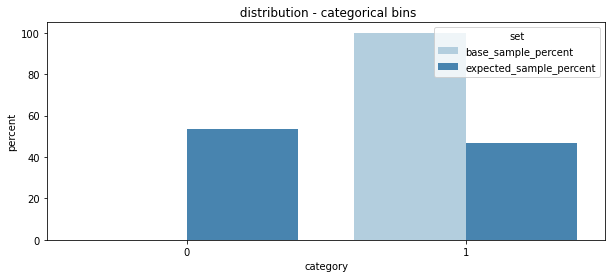

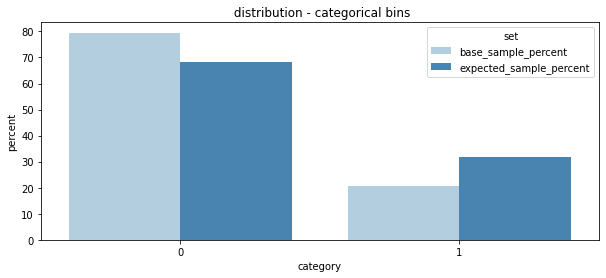

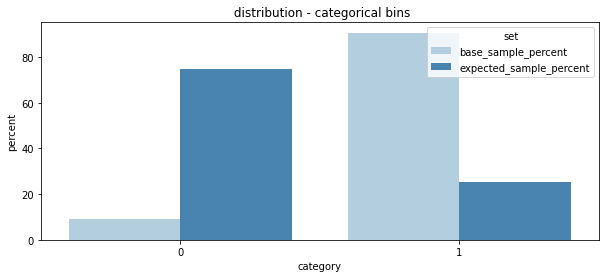

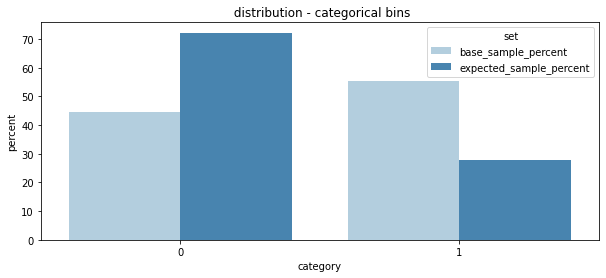

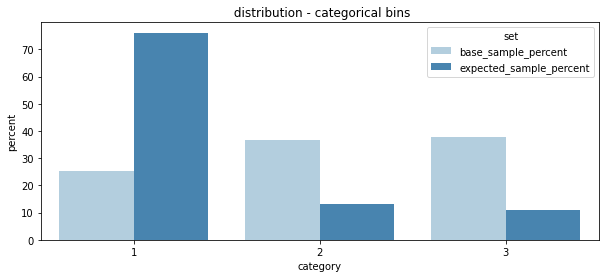

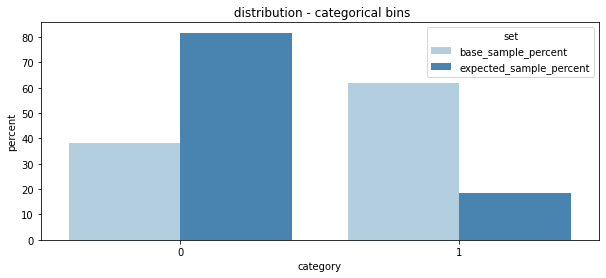

In [29]:
for col in independent_features:
    psi_score, psi_df = novo_ml_metrics.psi_categorical(actual=df_raw_v1_march23[df_raw_v1_march23.pred_prob>=0.6][col].values, 
                                                        expected=df_raw_v1_apr23[col].values, plot=True)
    print(col, 'psi score: ', psi_score)


estimated_monthly_revenue psi score:  nan
check_deposit_amount psi score:  0.064
outgoing_ach_and_checks psi score:  2.204
industry_group psi score:  0.324
business_age_bucket psi score:  1.157
bow_flag psi score:  0.853


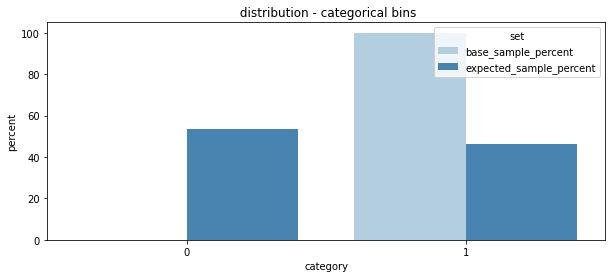

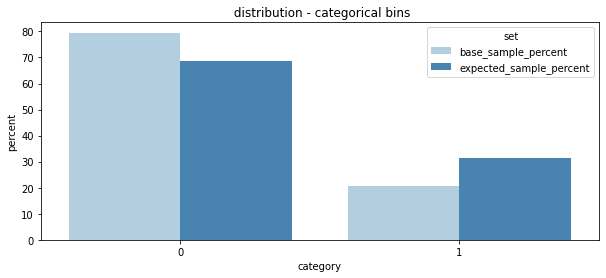

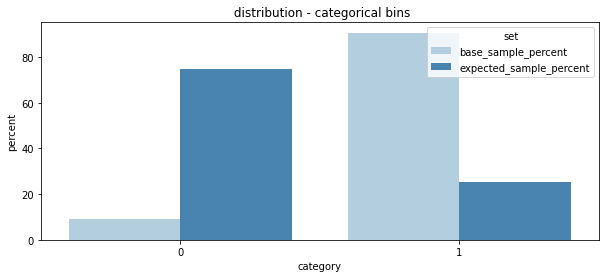

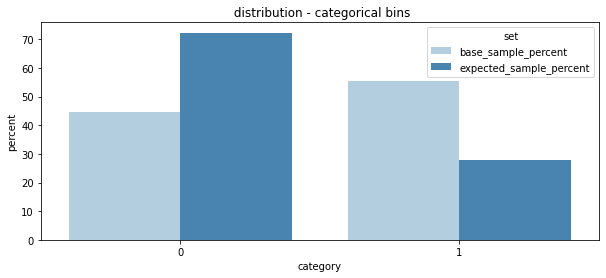

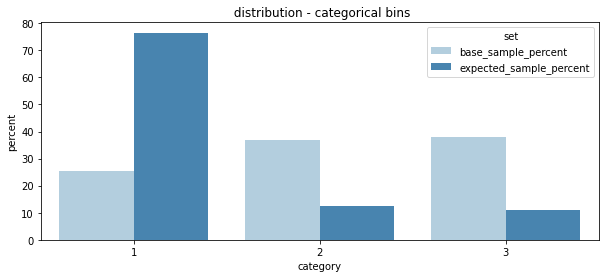

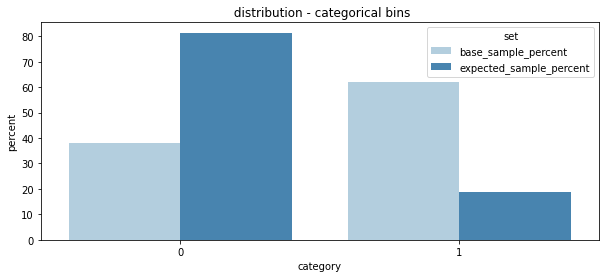

In [35]:
for col in independent_features:
    psi_score, psi_df = novo_ml_metrics.psi_categorical(actual=df_raw_v1_march23[df_raw_v1_march23.pred_prob>=0.6][col].values, 
                                                        expected=df_raw_v1_apr23[col].values, plot=True)
    print(col, 'psi score: ', psi_score)
